In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

device_gpu=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks",context="talk")
plt.style.use("dark_background")

import random

# Data Management

## Alphabets Setup

In [4]:
eng_alphabets='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char='-PAD-'

eng_alpha2index={pad_char:0}

for index,alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha]=index+1
    
print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [5]:
# Hindi Unicode Range is 2304:2432

hindi_alphabets=[chr(alpha) for alpha in range(2304,2432)]
hindi_alphabet_size=len(hindi_alphabets)

hindi_alpha2index={pad_char:0}

for index,alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha]=index+1
    

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

## Helper functions for data-preprocessing

In [6]:
import re
non_eng_letter_regex=re.compile('[^a-zA-Z ]')

#Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letter_regex.sub('', line)
    return line.split()



#Remove all Hindi Non-letters
def cleanHindiVocab(line):
    line=line.replace('-',' ').replace(',',' ')
    cleaned_line=''
    for char in line:
        if char in hindi_alpha2index or char==' ':
            cleaned_line+=char
            
    return cleaned_line.split()



## Dataset Loading


In [7]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):
    
    def  __init__(self,filename):
        self.eng_words,self.hindi_words=self.readXmlDataset(filename,cleanHindiVocab)
        self.shuffle_indices=list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index=0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self,idx):
        return self.eng_words[idx],self.hindi_words[idx]
    
    def readXmlDataset(self,filename,lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words=[]
        lang2_words=[]
        
        for line in transliterationCorpus:
            wordlist1=cleanEnglishVocab(line[0].text)
            wordlist2=lang_vocab_cleaner(line[1].text)
            
            #Skip Noisy Data
            if len(wordlist1)!=len(wordlist2):
                print('Skipping: ',line[0].text,'-',line[1].text)
                print(len(wordlist1),'  ',len(wordlist2))
                continue
                
            for word in wordlist1:
                lang1_words.append(word)
                
            for word in wordlist2:
                lang2_words.append(word)
                
        return lang1_words,lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self,batch_size,array):
        end=self.shuffle_start_index+batch_size
        batch=[]
        if end>=len(self.eng_words):
            batch=[array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end=len(self.eng_words)
            
        return batch+[array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]
    
    def get_batch(self,batch_size,postprocess=True):
        
        eng_batch=self.get_batch_from_array(batch_size,self.eng_words)
        hindi_batch=self.get_batch_from_array(batch_size,self.hindi_words)
        self.shuffle_start_index+=batch_size+1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index>=len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index=0
            
        return eng_batch,hindi_batch
        

In [8]:
train_data=TransliterationDataLoader('Training-EnHi-13937.txt')

Skipping:  BARHARWA JUNCTION - बरहरवा
2    1
Skipping:  STATE BNK TR - स्टेट बैंक ऑफ त्रावणकोर
3    4
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST - साउथ अर्लिंग्टन
5    2
Skipping:  KING EDWARD VII - किंग एडवर्ड
3    2
Skipping:  DIBANG VALLEY - दिबंगवैली
2    1
Skipping:  ORDER OF VASA - ऑडर ऑफ़ द वासा
3    4
Skipping:  AZAMNAGAR ROAD - आज़मनगर
2    1
Skipping:  CAPE TOWN - केपटाउन
2    1
Skipping:  NEW ZEALAND - न्यूज़ीलैंड
2    1
Skipping:  SEA OF THE HEBRIDES - सी ऑफ हरब्रिड्‍स
4    3
Skipping:  RAMCOIND - राम्को इंड
1    2
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM - केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
5    4
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY - ऑस्ट्रेलियननेशनल यूनिवर्सिटी
3    2
Skipping:  JAHAN AARA - जहाँआरा
2    1
Skipping:  NAVABHARAT FERRO ALLOYS - नव भारत फ़ैरो अलॉय
3    4
Skipping:  RAMA LINGESHWARA - रामालिंगेश्वर
2    1
Skipping:  FAKHRUN NISA - फखरुन्निसा
2    1
Skipping:  REDIFF.COM INDIA LIMITED - रेडिफ़ डॉट कॉम इंडिया लिमिटेड
3    5
Skipping:  OMKARNATH THAKUR 

In [9]:
test_data=TransliterationDataLoader('Test.xml')

# Basic Data Visualization

In [10]:
print('Train Set Size:\t',len(train_data))
print('Test set Size: \t',len(test_data))

Train Set Size:	 20543
Test set Size: 	 1000


In [11]:
print('\n Sample data from train-set:')
for i in range(10):
    eng,hindi=train_data.get_random_sample()
    print(eng+' - '+hindi)


 Sample data from train-set:
FANINDRA - फणींद्र
TAHIR - ताहिर
AMARESHWAR - अमरेश्वर
GLENN - ग्लेंन
LYNETTE - लिनेट
SHIPPING - शिपिंग
CHANDAUSI - चंदौसी
IKRAAR - इकरार
TIME - टाइम
AJITH - अजीथ


# Encoding the words

In [12]:
def word_rep(word,letter2index,device='cpu'):
    rep=torch.zeros(len(word)+1,1,len(letter2index)).to(device)
    for letter_index,letter in enumerate(word):
        pos=letter2index[letter]
        rep[letter_index][0][pos]=1
    pad_pos=letter2index[pad_char]
    rep[letter_index+1][0][pad_pos]=1
    return rep


In [13]:
def get_rep(word,letter2index,device='cpu'):
    
    gt_rep=torch.zeros([len(word)+1,1],dtype=torch.long).to(device)
    for letter_index,letter in enumerate(word):
        pos=letter2index[letter]
        gt_rep[letter_index][0]=pos
    gt_rep[letter_index+1][0]=letter2index[pad_char]
    return gt_rep

In [14]:
eng,hindi=train_data.get_random_sample()

In [15]:
eng_rep=word_rep(eng,eng_alpha2index)

In [16]:
print(eng,eng_rep)

MALIKA tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [17]:
hindi_gt=get_rep(hindi,hindi_alpha2index)

In [18]:
hindi_rep=word_rep(hindi,hindi_alpha2index)

In [19]:
print(hindi_gt)

tensor([[47],
        [51],
        [64],
        [22],
        [63],
        [ 0]])


In [20]:
print(hindi_rep)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0

# Network architecture


## Encoder-Decoder (Using GRU)

In [21]:
MAX_OUTPUT_CHARS=30

In [22]:
class Transliteration_EncoderDecoder(nn.Module):
    
    def __init__(self,input_size,hidden_size,output_size,verbose=False):
        
        super(Transliteration_EncoderDecoder,self).__init__()
        
        self.hidden_size=hidden_size
        self.output_size=output_size
        
        self.encoder_rnn_cell=nn.GRU(input_size,hidden_size)
        self.decoder_rnn_cell=nn.GRU(output_size,hidden_size)
        
        self.h2o=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=2)
        self.verbose=verbose
        
    def forward(self,input_,max_output_chars=MAX_OUTPUT_CHARS,device='cpu',ground_truth=None):
        
        #encoder
        out,hidden=self.encoder_rnn_cell(input_)
        
        if self.verbose:
            print("Encoder Input",input_.shape)
            print("Enoder Output",out.shape)
            print("Encoder hidden",hidden.shape)
            
        #decoder
        decoder_state=hidden
        decoder_input=torch.zeros(1,1,self.output_size).to(device)
        outputs=[]
        
        if self.verbose:
            
            print('Decoder state',decoder_state.shape)
            print('Decoder input',decoder_input.shape)
            
        
        for i in range(max_output_chars):
            
            out,decoder_state=self.decoder_rnn_cell(decoder_input,decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output',out.shape)
                
            out=self.h2o(decoder_state)
            out=self.softmax(out)
            outputs.append(out.view(1,-1))
            
            if self.verbose:
                print('Decoder output',out.shape)
                self.verbose=False
                
                
            max_idx=torch.argmax(out,2,keepdim=True)
            #print('max_idx',max_idx)
            if not ground_truth is None:
                max_idx=ground_truth[i].reshape(1,1,1)
            one_hot=torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2,max_idx,1)
            
            decoder_input=one_hot.detach()
            
        
        return outputs
            
            
            

In [23]:
def infer(net,word,max_output_chars,device='cpu'):
    
    net.eval().to(device)
    word_ohe=word_rep(word,eng_alpha2index)
    output=net(word_ohe,max_output_chars)
    return output

In [24]:
net=Transliteration_EncoderDecoder(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)

In [25]:
out=infer(net,'INDIA',30)

Encoder Input torch.Size([6, 1, 27])
Enoder Output torch.Size([6, 1, 256])
Encoder hidden torch.Size([1, 1, 256])
Decoder state torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 129])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


In [26]:
print(len(out))

30


In [27]:
for i in range(len(out)):
    print(out[i].shape,list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])
    

torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) ऻ
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) ऻ
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) ऻ
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) ऻ
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) ऻ
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) ऻ
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़
torch.Size([1, 129]) ऻ
torch.Size([1, 129]) य़
torch.Size([1, 129]) य़


# Encoder-decoder with Attention

In [28]:
class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self,input_size,hidden_size,output_size,verbose=False):
        
        super(Transliteration_EncoderDecoder_Attention,self).__init__()
        
        self.hidden_size=hidden_size
        self.output_size=output_size
        
        self.encoder_rnn_cell=nn.GRU(input_size,hidden_size)
        self.decoder_rnn_cell=nn.GRU(hidden_size*2,hidden_size)
        
        self.h2o=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=2)
        
        self.U=nn.Linear(self.hidden_size,self.hidden_size)
        self.W=nn.Linear(self.hidden_size,self.hidden_size)
        
        self.attn=nn.Linear(hidden_size,1) 
        self.out2hidden=nn.Linear(self.output_size,self.hidden_size)
        
        self.verbose=verbose
        
        
        
    def forward(self,input_,max_output_chars=MAX_OUTPUT_CHARS,device='cpu',ground_truth=None):
        
        #encoder
        encoder_outputs,hidden=self.encoder_rnn_cell(input_)
        
        if self.verbose:
            print('Encoder output',encoder_outputs.shape)
        
        encoder_outputs=encoder_outputs.view(-1,self.hidden_size)
        
        if self.verbose:
            print('Encoder output',encoder_outputs.shape)
            
        #decoder
        decoder_state=hidden
        decoder_input=torch.zeros(1,1,self.output_size).to(device)
        
        outputs=[]
        U=self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state',decoder_state.shape)
            print('Decoder first inputs',decoder_input.shape)
            print('U*Encoder output',U.shape)
            
        for i in range(max_output_chars):
            
            W=self.W(decoder_state.view(1,-1).repeat(encoder_outputs.shape[0],1))
            V=self.attn(torch.tanh(U+W))
            
            attn_weights=F.softmax(V.view(1,-1),dim=1)
            
            if self.verbose:
                print('W*Decoder State',W.shape)
                print('V',V.shape)
                print('Attn',attn_weights.shape)
                print('attn_weights',attn_weights.shape)
                print('attn_weights.unsqueeze(0)',attn_weights.unsqueeze(0).shape)
                print('encoder_outputs',encoder_outputs.shape)
                print('encoder_outputs.unsqueeze(0)',encoder_outputs.unsqueeze(0).shape)
                
            attn_applied=torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
            
            embedding=self.out2hidden(decoder_input)
            
            decoder_input=torch.cat((embedding[0],attn_applied[0]),1).unsqueeze(0)
            
            
            if self.verbose:
                print('Att applied',attn_applied.shape)
                print('Decoder input',decoder_input.shape)
                
            out,decoder_state=self.decoder_rnn_cell(decoder_input,decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output',out.shape)
                
            out=self.h2o(decoder_state)
            out=self.softmax(out)
            outputs.append(out.view(1,-1))
            
            if self.verbose:
                print('Decoder Output',out.shape)
                self.verbose=False
                
            max_idx=torch.argmax(out,2,keepdim=True)
            if not ground_truth is None:
                max_idx=ground_truth[i].reshape(1,1,1)
                
            one_hot=torch.zeros(out.shape,device=device)
            one_hot.scatter_(2,max_idx,1)
            
            decoder_input=one_hot.detach()
            
        return outputs
    

In [29]:
net__att=Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)

In [30]:
out=infer(net__att,'INDIA',30)

Encoder output torch.Size([6, 1, 256])
Encoder output torch.Size([6, 256])
Decoder state torch.Size([1, 1, 256])
Decoder first inputs torch.Size([1, 1, 129])
U*Encoder output torch.Size([6, 256])
W*Decoder State torch.Size([6, 256])
V torch.Size([6, 1])
Attn torch.Size([1, 6])
attn_weights torch.Size([1, 6])
attn_weights.unsqueeze(0) torch.Size([1, 1, 6])
encoder_outputs torch.Size([6, 256])
encoder_outputs.unsqueeze(0) torch.Size([1, 6, 256])
Att applied torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder Output torch.Size([1, 1, 129])


In [31]:
print(len(out))

30


In [32]:
for i in range(len(out)):
    print(out[i].shape,list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

torch.Size([1, 129]) ऒ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ
torch.Size([1, 129]) ॐ


# Training

# Core Trainer

In [33]:
def train_batch(net,opt,criterion,batch_size,device='cpu',teacher_force=False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch,hindi_batch=train_data.get_batch(batch_size)
    
    total_loss=0
    for i in range(batch_size):
        #print(i)
        input_=word_rep(eng_batch[i],eng_alpha2index,device)
        gt=get_rep(hindi_batch[i],hindi_alpha2index,device)
        outputs=net(input_,gt.shape[0],device,ground_truth=gt if teacher_force else None)
        
        for index,output in enumerate(outputs):
            loss=criterion(output,gt[index])/batch_size
            loss.backward(retain_graph=True)
            total_loss+=loss
            
    opt.step()
    
    return total_loss/batch_size

# Training Helper

In [38]:
def train_setup(net,lr=0.01,n_batches=100,batch_size=10,momentum=0.9,display_freq=5,device='cpu'):
    
    net=net.to(device)
    criterion=nn.NLLLoss(ignore_index=-1)
    opt=optim.Adam(net.parameters(),lr=lr)
    teacher_force_upto=n_batches//3
    
    loss_arr=np.zeros(n_batches+1)
    
    for i in range(n_batches):
        
        #print(i)
        loss_arr[i+1]=(loss_arr[i]*i+train_batch(net,opt,criterion,batch_size,device=device,teacher_force=i<teacher_force_upto))/(i+1)

        if i%display_freq==display_freq-1:
        
            print('Iteration ',i,' Loss',loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
        
    torch.save(net,'model.pt')  
    return loss_arr

# Training without Attention

Iteration  9  Loss 0.3968806862831116


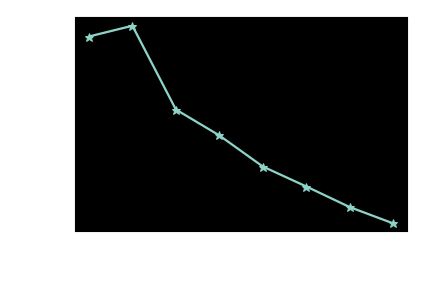




Iteration  19  Loss 0.36267438530921936


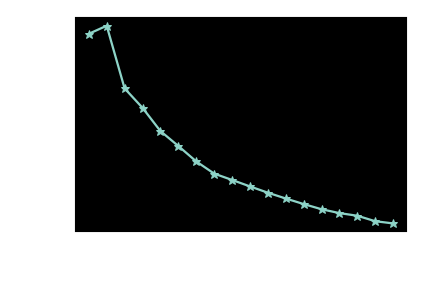




Iteration  29  Loss 0.3435680866241455


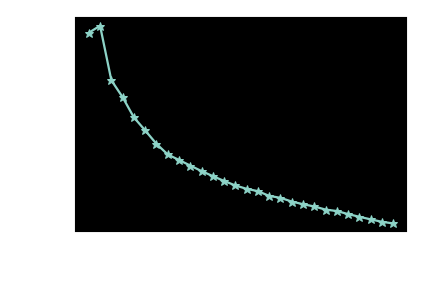




Iteration  39  Loss 0.32899072766304016


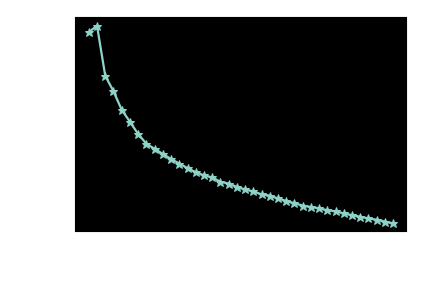




Iteration  49  Loss 0.3174329698085785


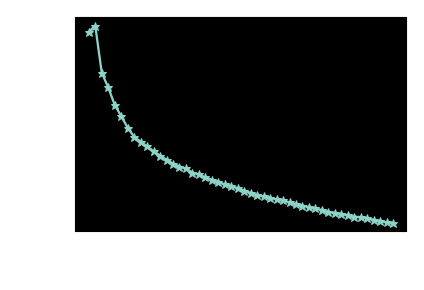




Iteration  59  Loss 0.306425541639328


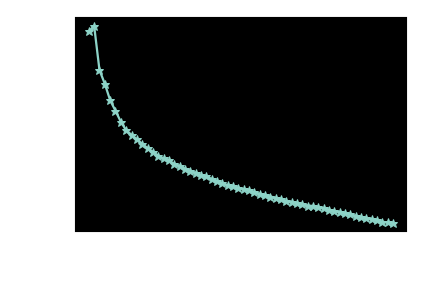




Iteration  69  Loss 0.2967667877674103


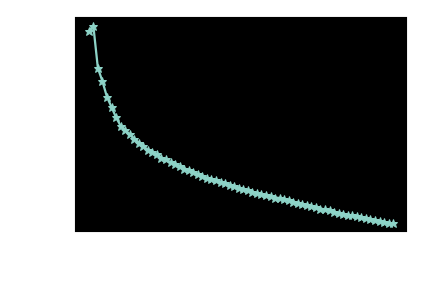




Iteration  79  Loss 0.2862527370452881


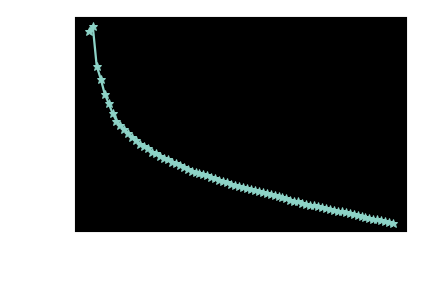




Iteration  89  Loss 0.2769271433353424


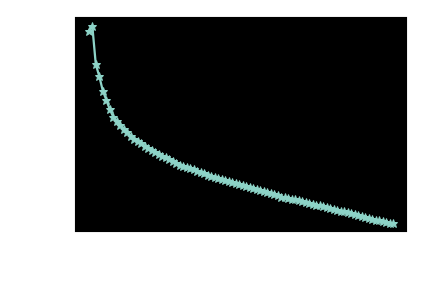




Iteration  99  Loss 0.2674001157283783


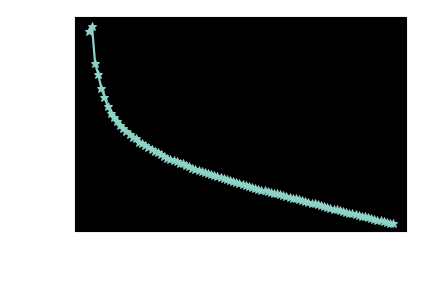




Iteration  109  Loss 0.25873062014579773


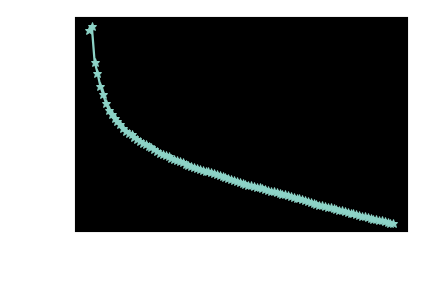




Iteration  119  Loss 0.25014692544937134


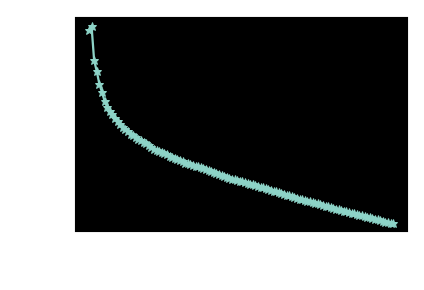




Iteration  129  Loss 0.24191293120384216


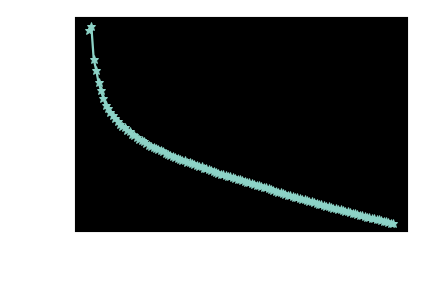




Iteration  139  Loss 0.23417545855045319


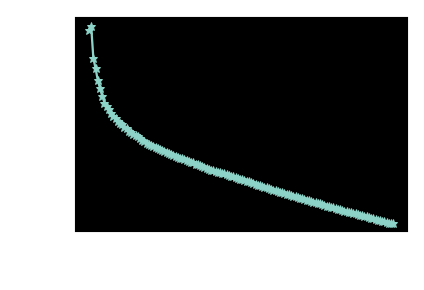




Iteration  149  Loss 0.22713477909564972


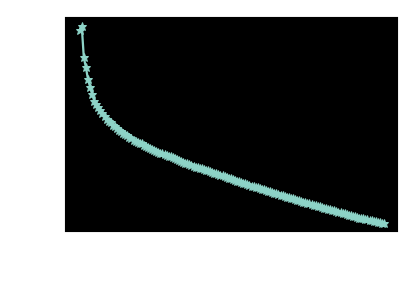




Iteration  159  Loss 0.22034907341003418


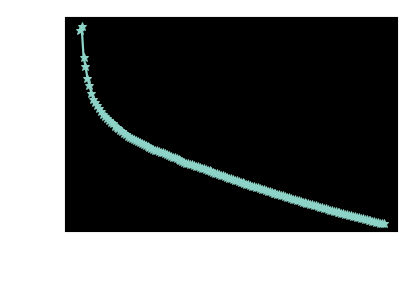




Iteration  169  Loss 0.2140519618988037


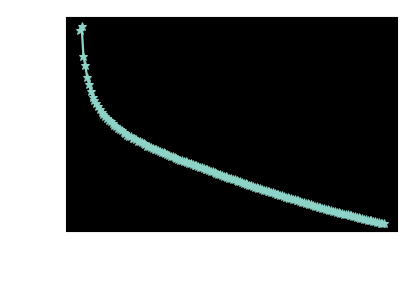




Iteration  179  Loss 0.20833589136600494


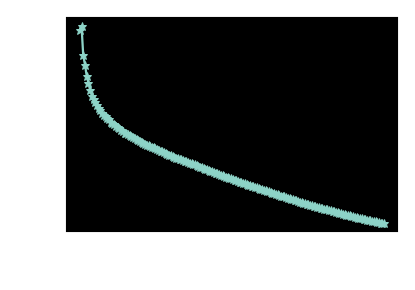




Iteration  189  Loss 0.20291617512702942


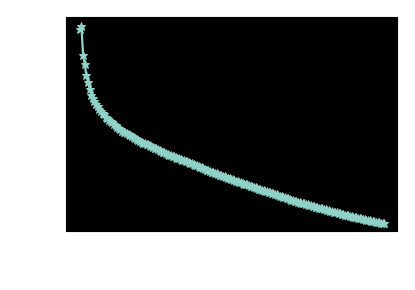




Iteration  199  Loss 0.19784358143806458


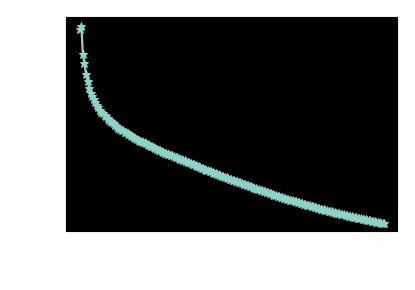




Iteration  209  Loss 0.19304829835891724


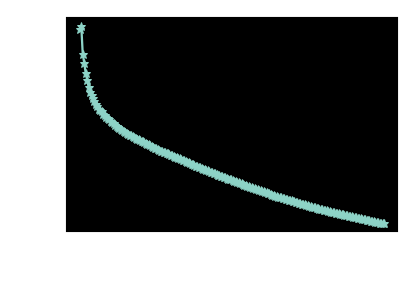




Iteration  219  Loss 0.1884070485830307


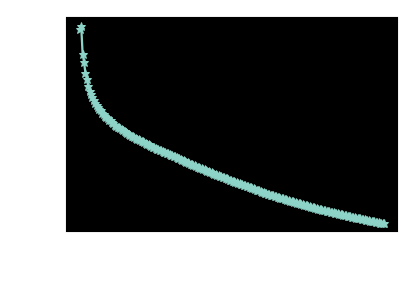




Iteration  229  Loss 0.18442852795124054


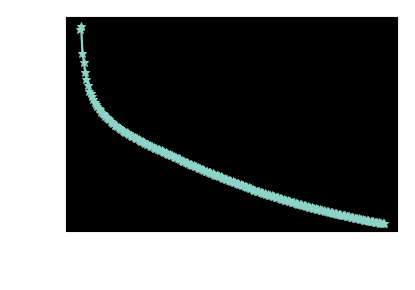




Iteration  239  Loss 0.180491641163826


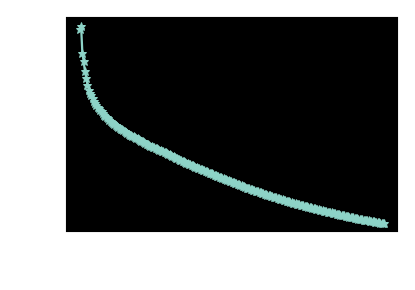




Iteration  249  Loss 0.17691512405872345


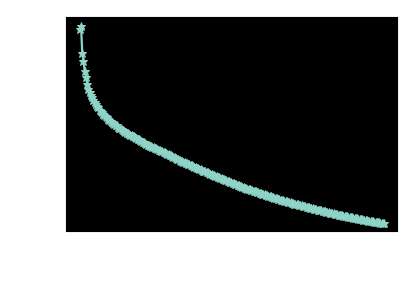




Iteration  259  Loss 0.1733693927526474


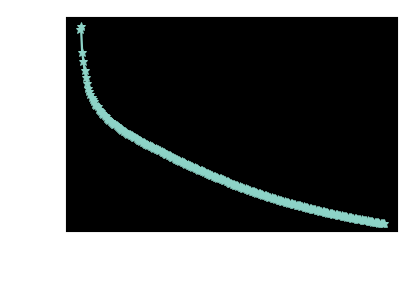




Iteration  269  Loss 0.17005392909049988


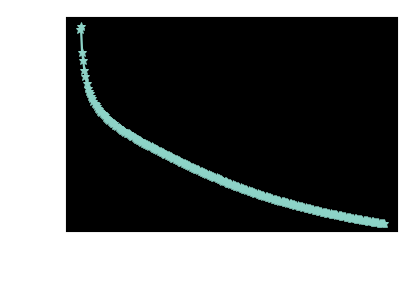




Iteration  279  Loss 0.16714708507061005


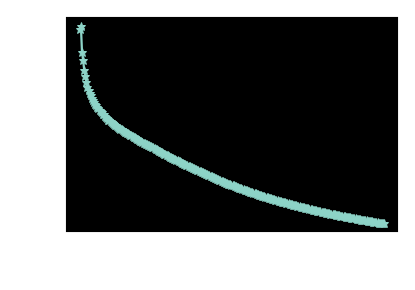




Iteration  289  Loss 0.16439980268478394


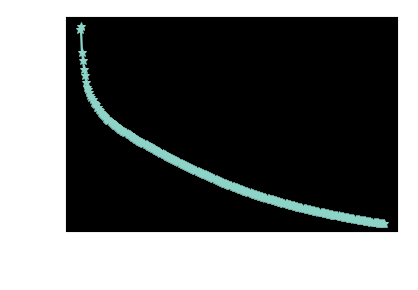




Iteration  299  Loss 0.16164954006671906


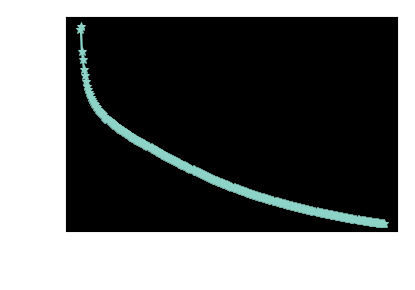




Iteration  309  Loss 0.1592162400484085


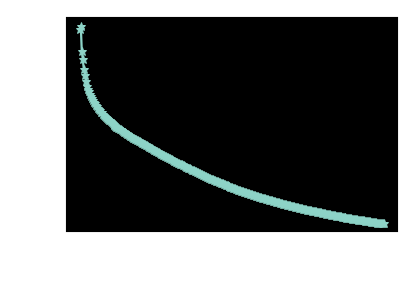




Iteration  319  Loss 0.15670377016067505


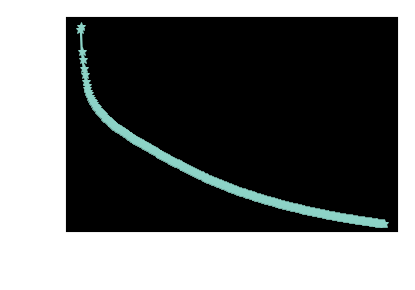




Iteration  329  Loss 0.15428735315799713


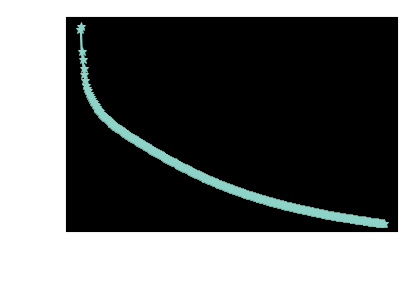




Iteration  339  Loss 0.153913676738739


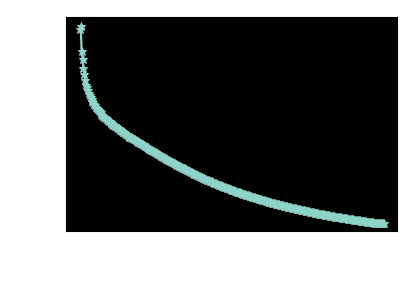




Iteration  349  Loss 0.1540951430797577


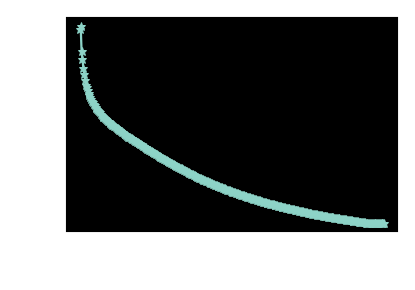




Iteration  359  Loss 0.153744637966156


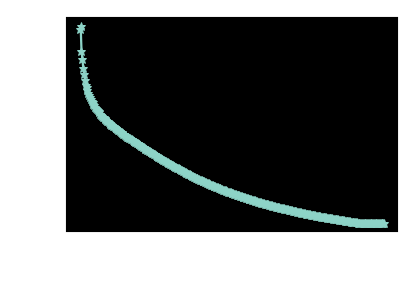




Iteration  369  Loss 0.15324410796165466


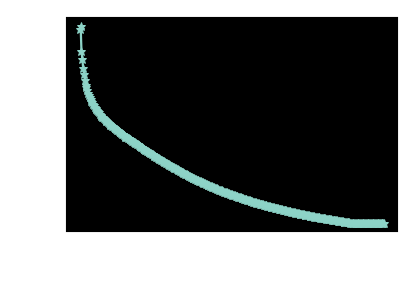




Iteration  379  Loss 0.15269364416599274


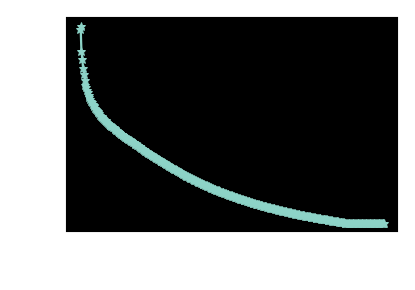




Iteration  389  Loss 0.15243393182754517


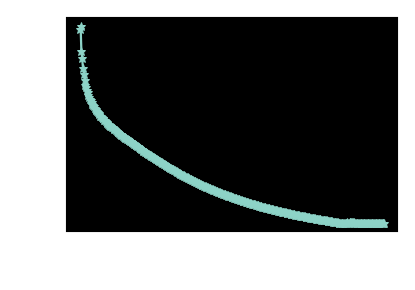




Iteration  399  Loss 0.15176528692245483


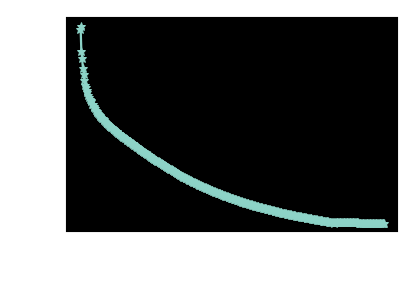




Iteration  409  Loss 0.1510077714920044


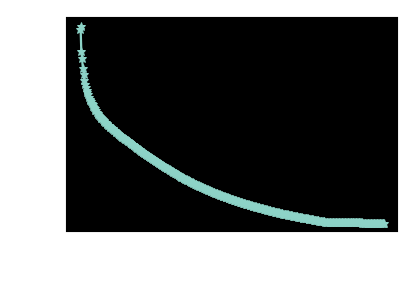




Iteration  419  Loss 0.1503051519393921


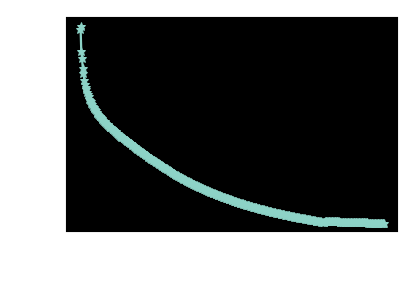




Iteration  429  Loss 0.14969351887702942


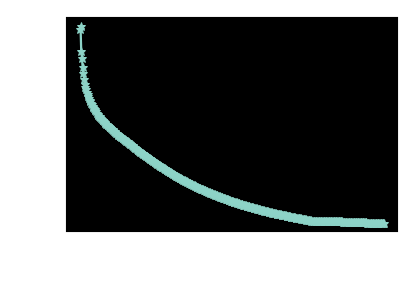




Iteration  439  Loss 0.14916808903217316


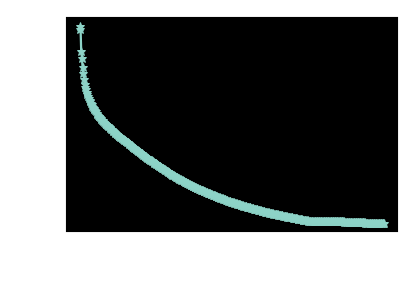




Iteration  449  Loss 0.14842969179153442


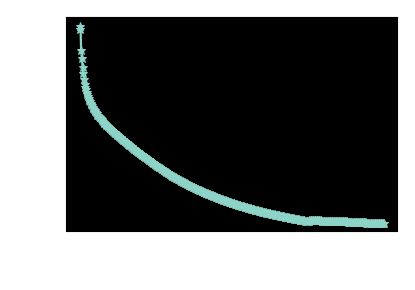




Iteration  459  Loss 0.14776556193828583


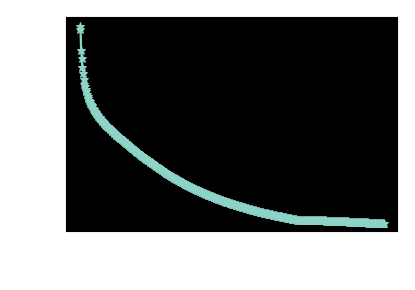




Iteration  469  Loss 0.14722001552581787


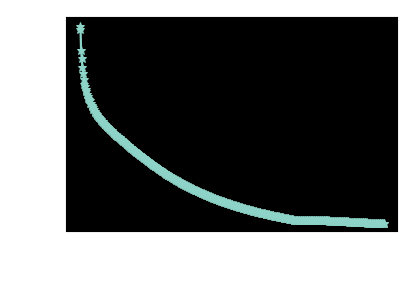




Iteration  479  Loss 0.14650830626487732


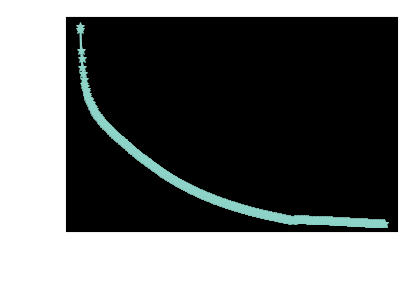




Iteration  489  Loss 0.14586389064788818


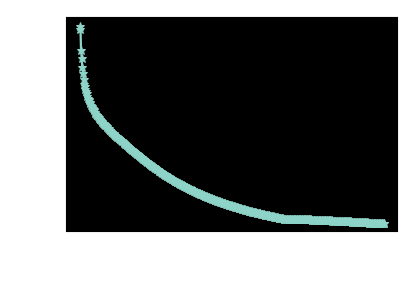




Iteration  499  Loss 0.1450604945421219


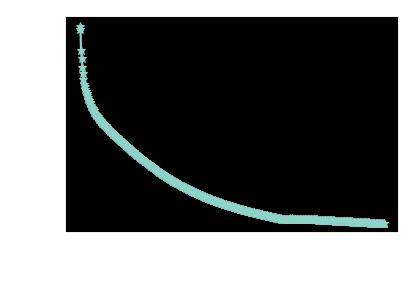




Iteration  509  Loss 0.14429108798503876


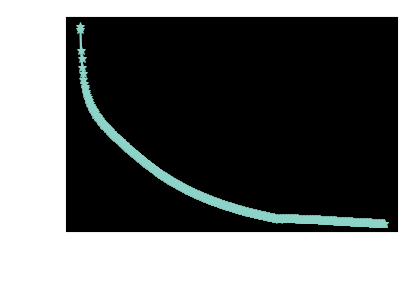




Iteration  519  Loss 0.1435057371854782


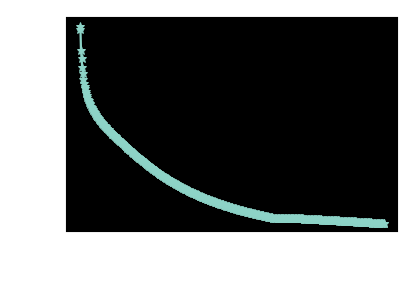




Iteration  529  Loss 0.1429908722639084


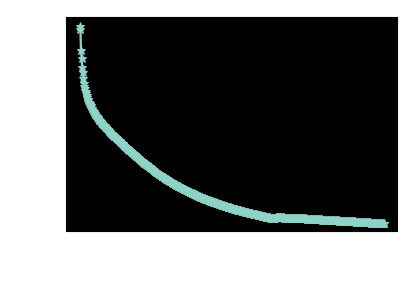




Iteration  539  Loss 0.14228548109531403


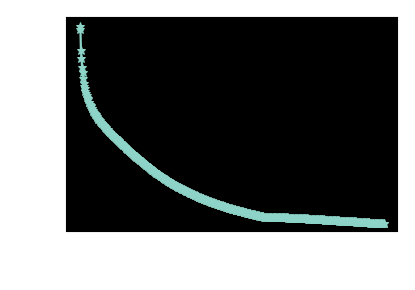




Iteration  549  Loss 0.14176136255264282


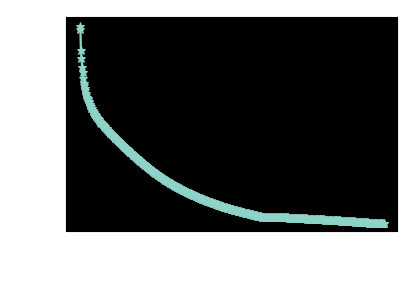




Iteration  559  Loss 0.14130041003227234


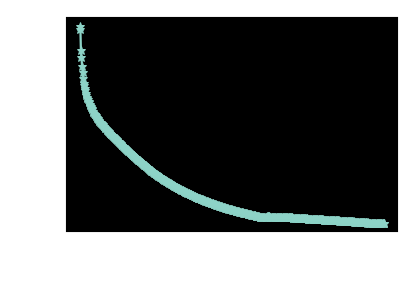




Iteration  569  Loss 0.14070020616054535


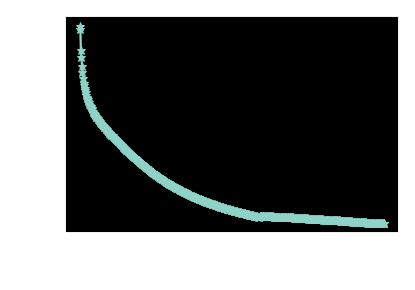




Iteration  579  Loss 0.14020299911499023


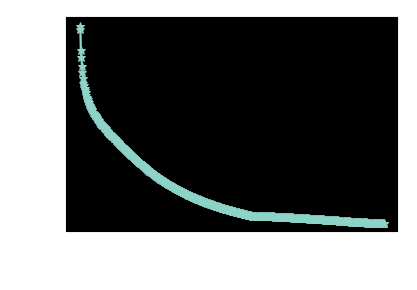




Iteration  589  Loss 0.13969089090824127


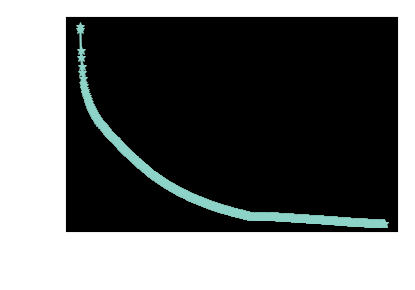




Iteration  599  Loss 0.13906896114349365


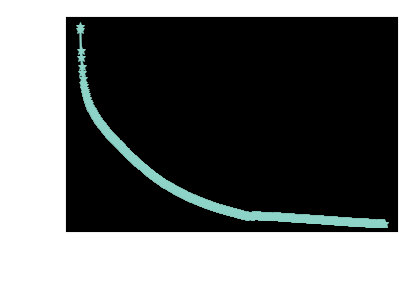




Iteration  609  Loss 0.13861188292503357


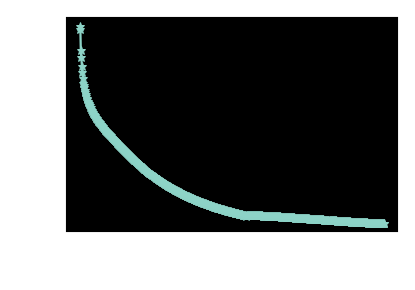




Iteration  619  Loss 0.13814383745193481


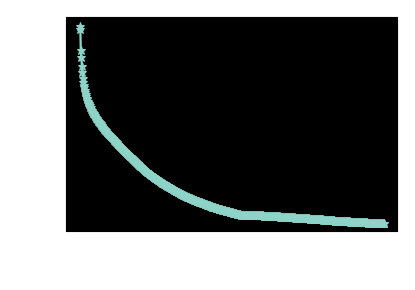




Iteration  629  Loss 0.1376873403787613


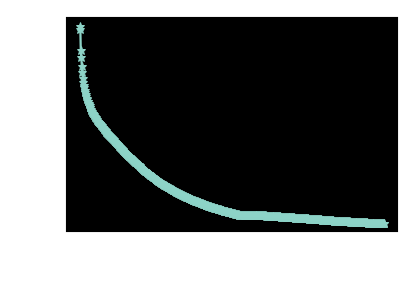




Iteration  639  Loss 0.13717956840991974


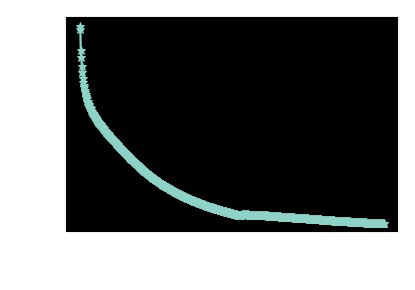




Iteration  649  Loss 0.13673841953277588


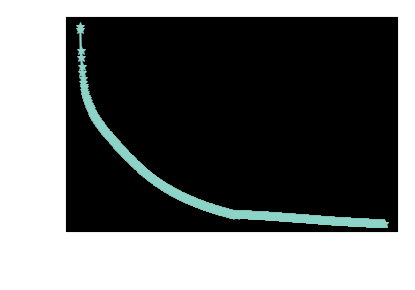




Iteration  659  Loss 0.1362384557723999


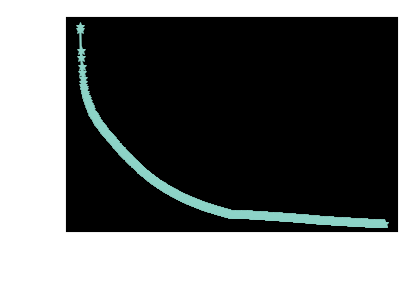




Iteration  669  Loss 0.13574349880218506


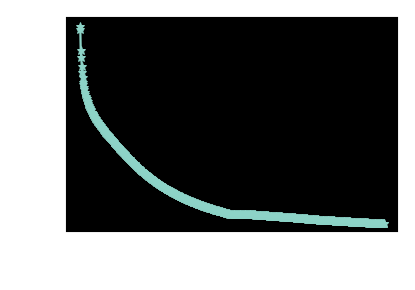




Iteration  679  Loss 0.1352464258670807


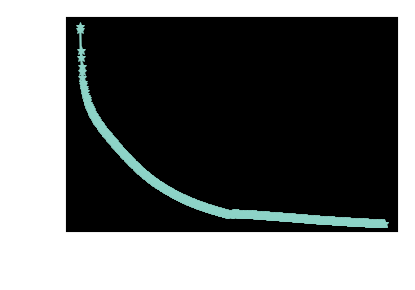




Iteration  689  Loss 0.13474449515342712


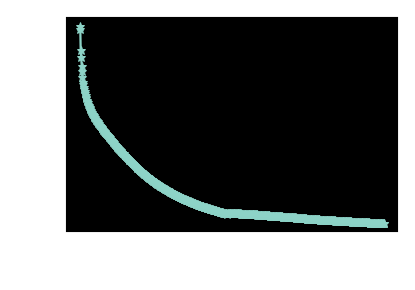




Iteration  699  Loss 0.13416968286037445


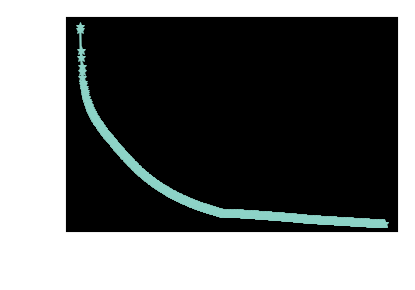




Iteration  709  Loss 0.1337110698223114


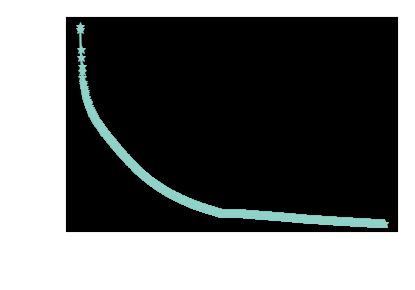




Iteration  719  Loss 0.13335449993610382


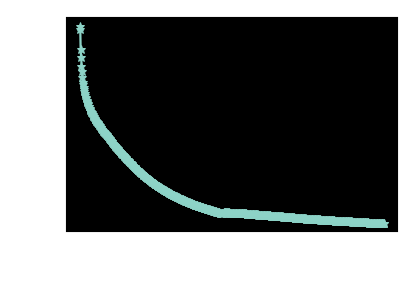




Iteration  729  Loss 0.13298816978931427


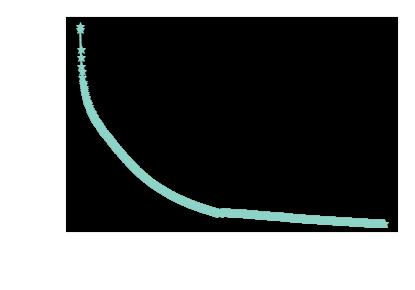




Iteration  739  Loss 0.13257643580436707


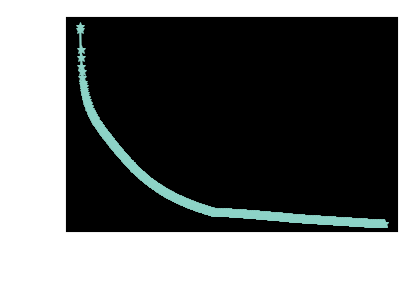




Iteration  749  Loss 0.13211707770824432


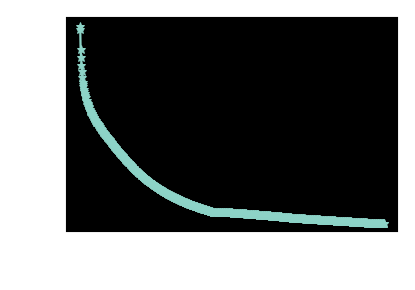




Iteration  759  Loss 0.13170428574085236


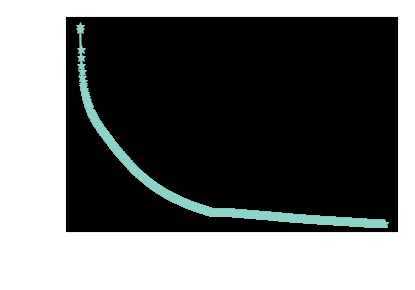




Iteration  769  Loss 0.13127745687961578


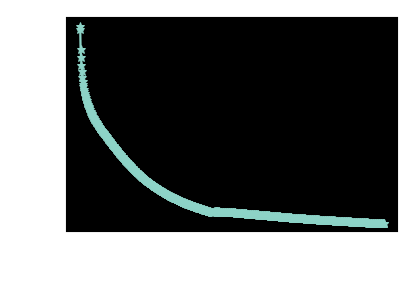




Iteration  779  Loss 0.13074813783168793


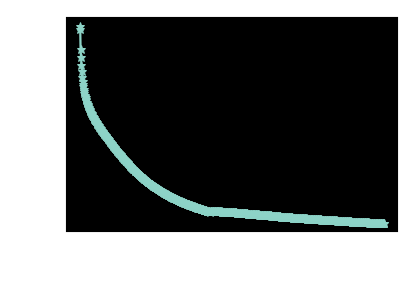




Iteration  789  Loss 0.13026006519794464


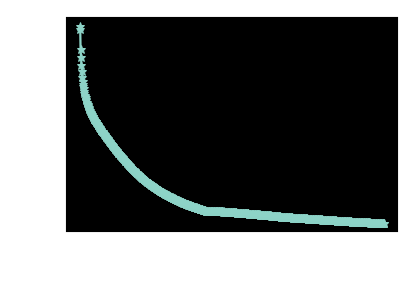




Iteration  799  Loss 0.12974964082241058


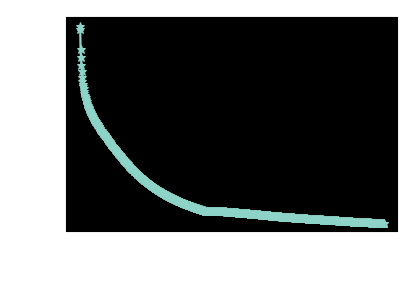




Iteration  809  Loss 0.12935952842235565


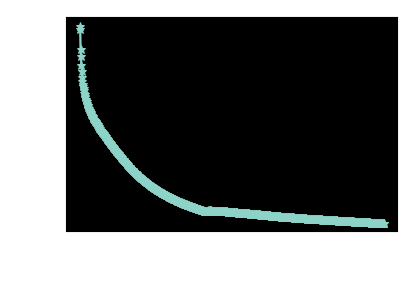




Iteration  819  Loss 0.1288759559392929


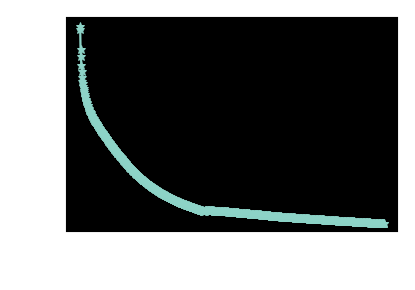




Iteration  829  Loss 0.12846943736076355


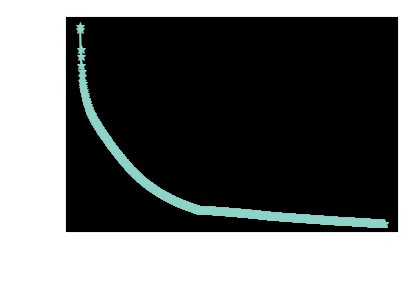




Iteration  839  Loss 0.12810173630714417


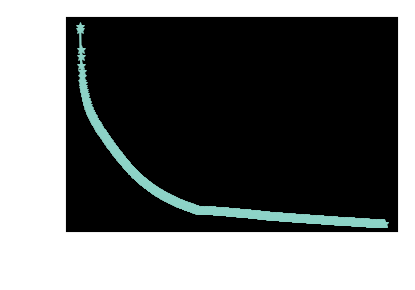




Iteration  849  Loss 0.12766021490097046


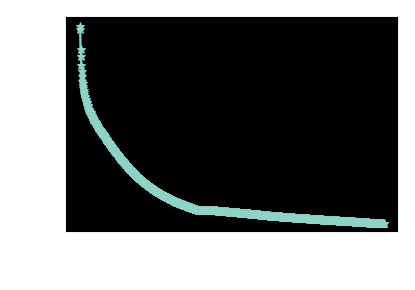




Iteration  859  Loss 0.12725231051445007


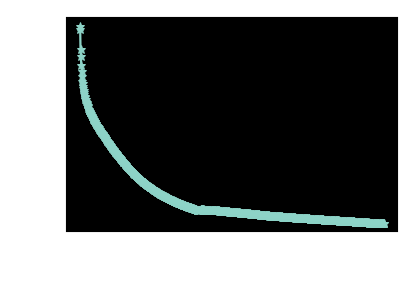




Iteration  869  Loss 0.1268480122089386


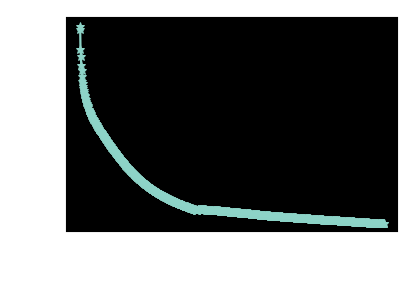




Iteration  879  Loss 0.1264946609735489


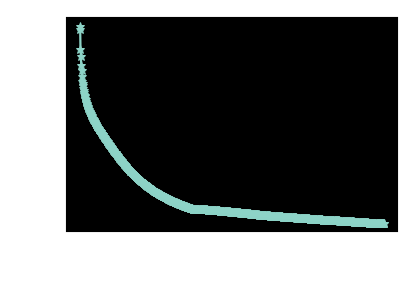




Iteration  889  Loss 0.12619543075561523


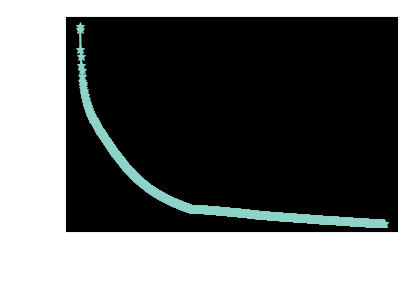




Iteration  899  Loss 0.1258440613746643


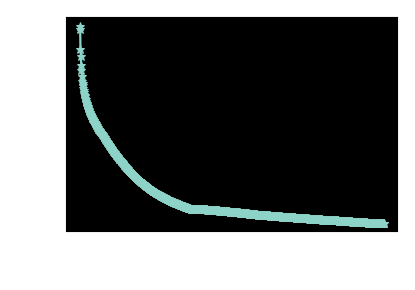




Iteration  909  Loss 0.1255069077014923


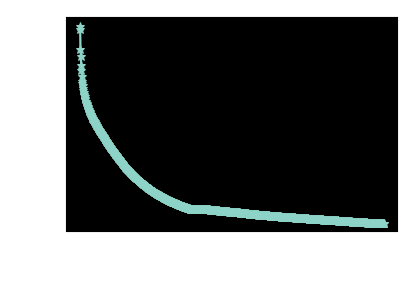




Iteration  919  Loss 0.1251189112663269


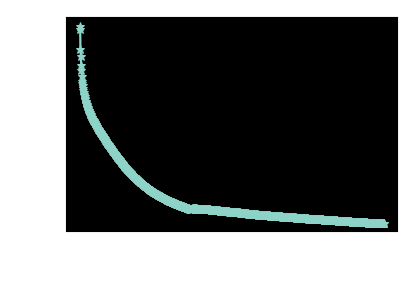




Iteration  929  Loss 0.12480368465185165


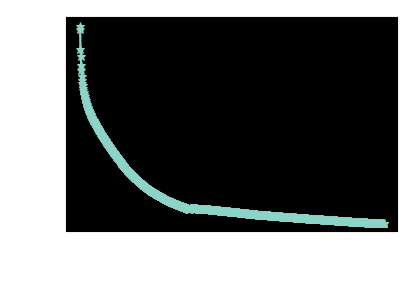




Iteration  939  Loss 0.12445797026157379


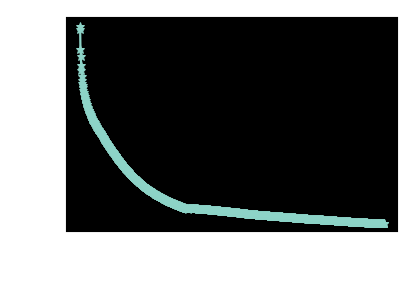




Iteration  949  Loss 0.12411530315876007


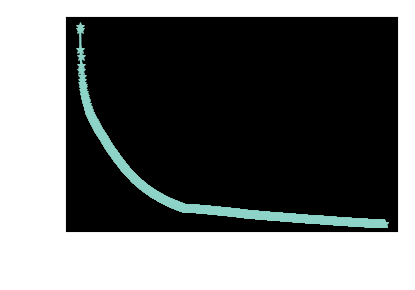




Iteration  959  Loss 0.12375912815332413


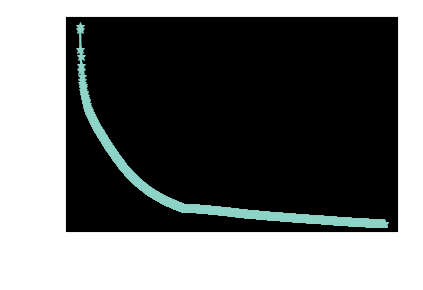




Iteration  969  Loss 0.12340541183948517


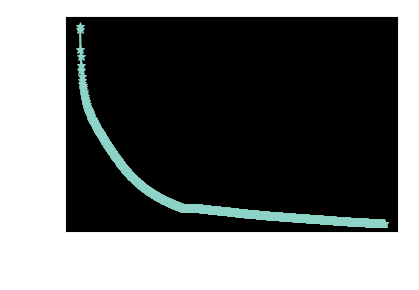




Iteration  979  Loss 0.12316416203975677


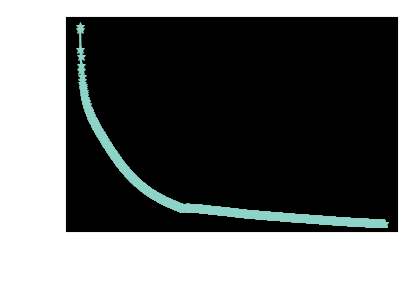




Iteration  989  Loss 0.12280689924955368


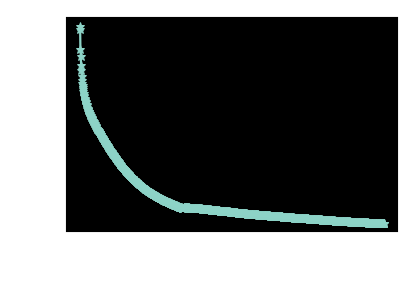




Iteration  999  Loss 0.12251760810613632


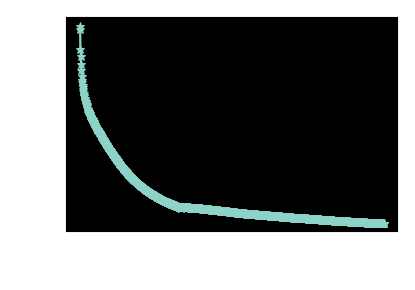

In [59]:
net=Transliteration_EncoderDecoder(len(eng_alpha2index),256,len(hindi_alpha2index))

loss_history1=train_setup(net,lr=0.01,n_batches=1000,batch_size=64,display_freq=10,device=device_gpu)

# Training with Attention

In [60]:
net_att=Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index))


Iteration  9  Loss 0.38945305347442627


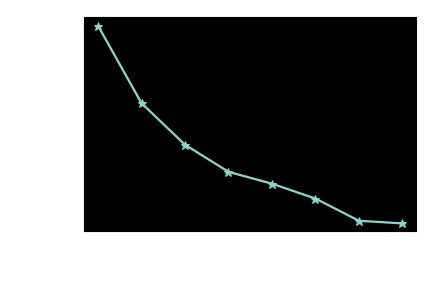




Iteration  19  Loss 0.36505913734436035


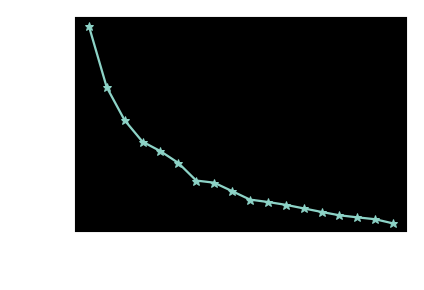




Iteration  29  Loss 0.34293487668037415


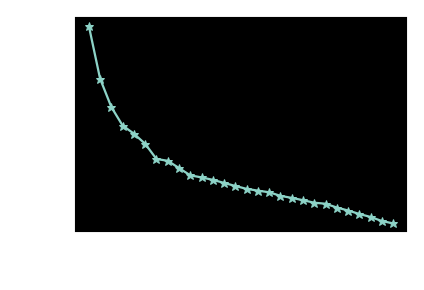




Iteration  39  Loss 0.32614749670028687


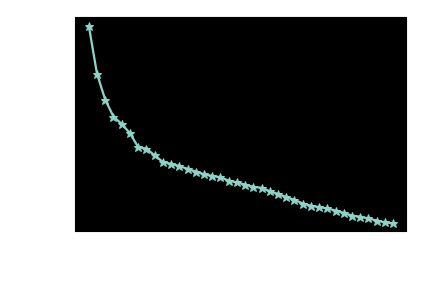




Iteration  49  Loss 0.30925247073173523


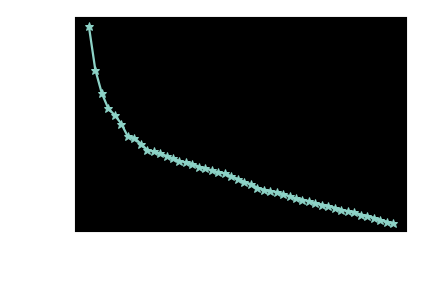




Iteration  59  Loss 0.2955308258533478


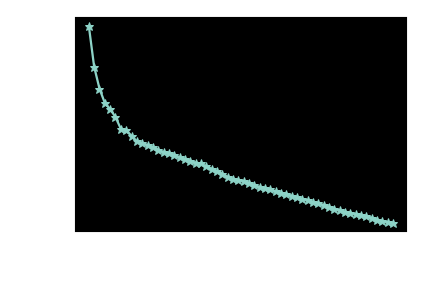




Iteration  69  Loss 0.2803300619125366


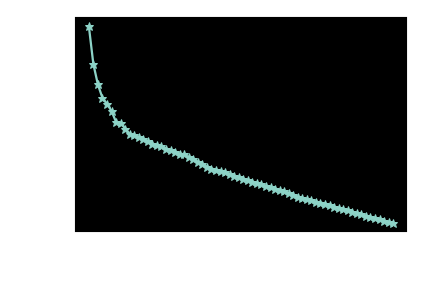




Iteration  79  Loss 0.26484447717666626


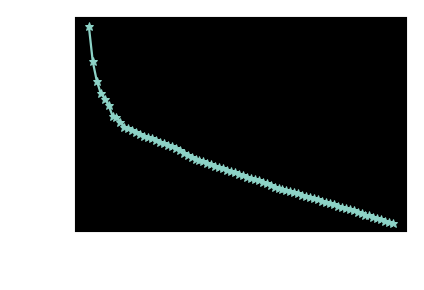




Iteration  89  Loss 0.2506142854690552


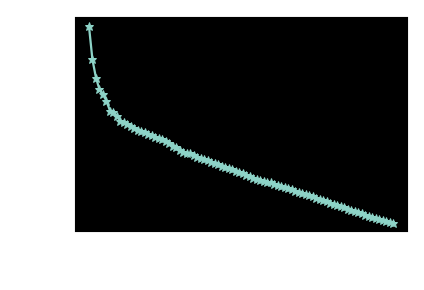




Iteration  99  Loss 0.23791615664958954


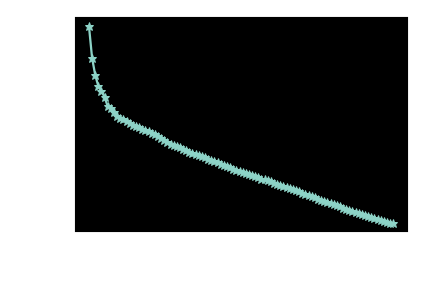




Iteration  109  Loss 0.22729943692684174


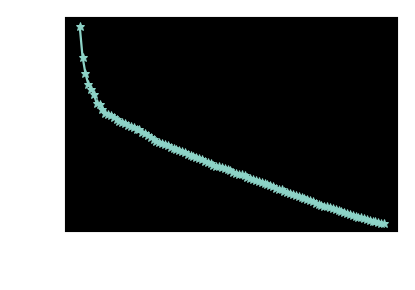




Iteration  119  Loss 0.21700993180274963


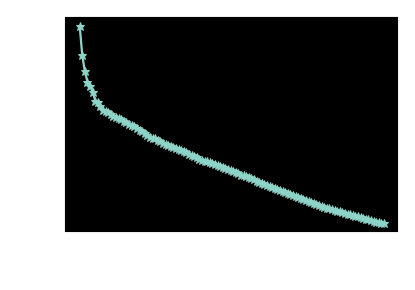




Iteration  129  Loss 0.20808710157871246


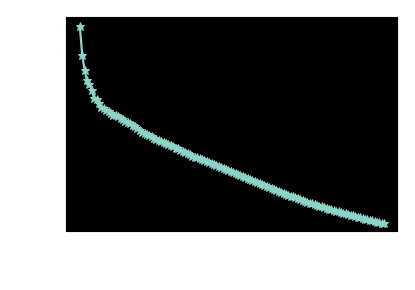




Iteration  139  Loss 0.20012302696704865


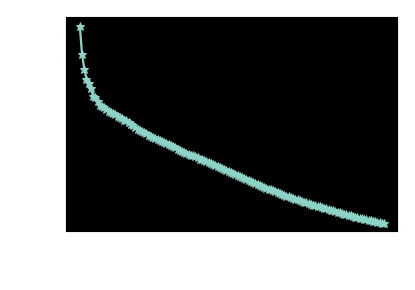




Iteration  149  Loss 0.1930576115846634


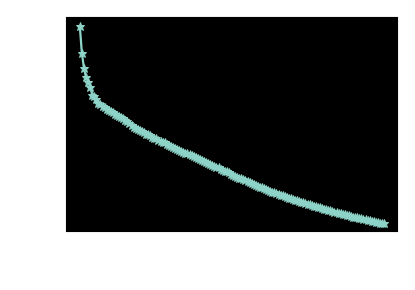




Iteration  159  Loss 0.1869383156299591


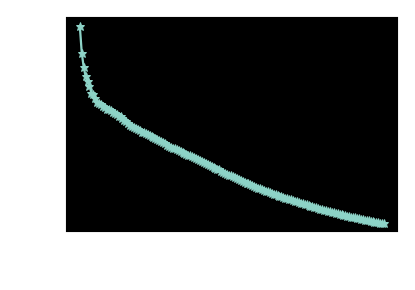




Iteration  169  Loss 0.1808352917432785


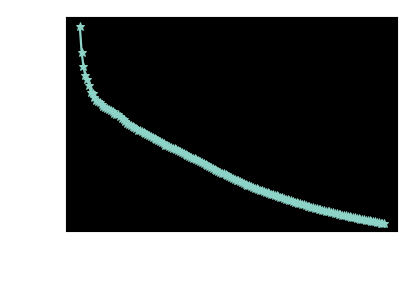




Iteration  179  Loss 0.17528066039085388


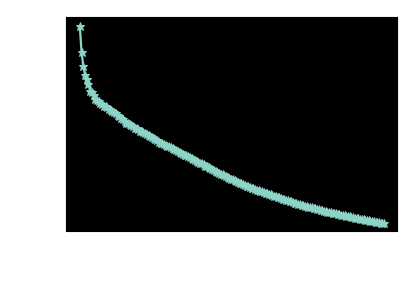




Iteration  189  Loss 0.17040887475013733


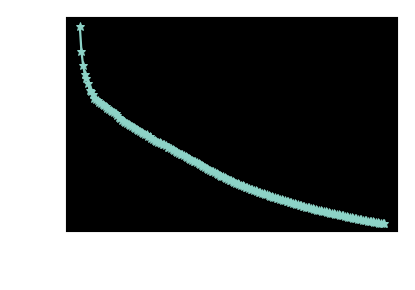




Iteration  199  Loss 0.1658301204442978


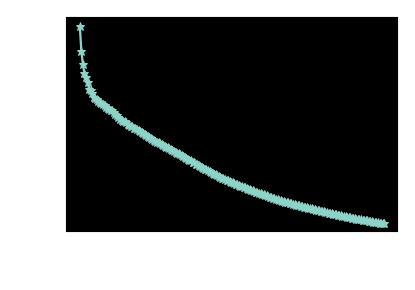




Iteration  209  Loss 0.1617460399866104


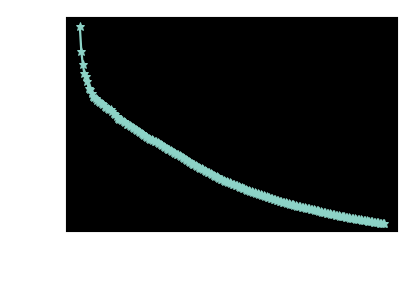




Iteration  219  Loss 0.15806925296783447


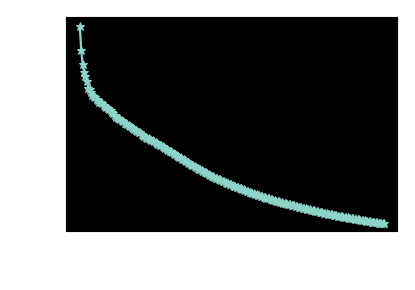




Iteration  229  Loss 0.1543235182762146


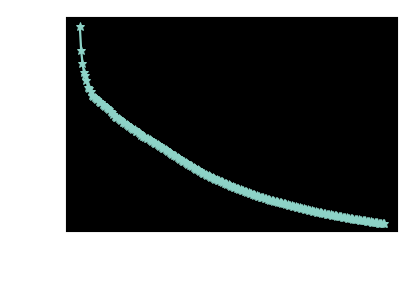




Iteration  239  Loss 0.1508697271347046


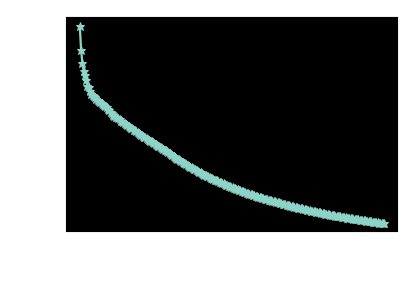




Iteration  249  Loss 0.14756061136722565


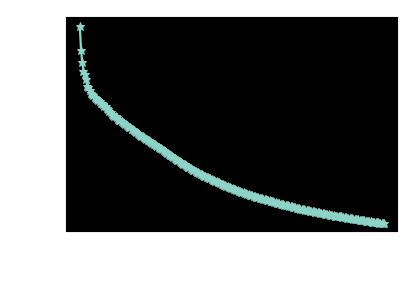




Iteration  259  Loss 0.1444711834192276


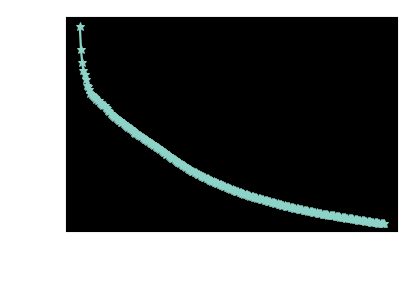




Iteration  269  Loss 0.14162097871303558


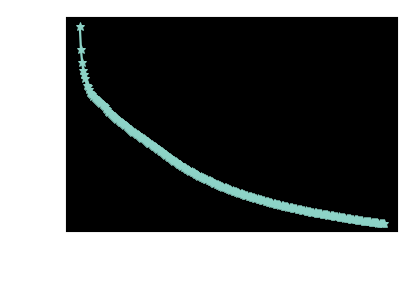




Iteration  279  Loss 0.1390962153673172


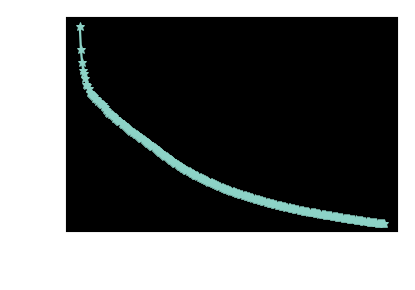




Iteration  289  Loss 0.13663212954998016


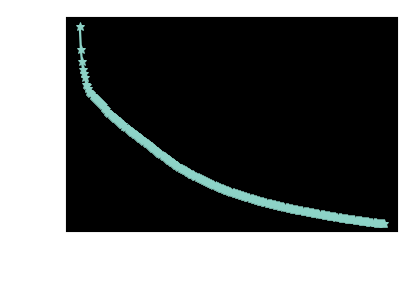




Iteration  299  Loss 0.13422806560993195


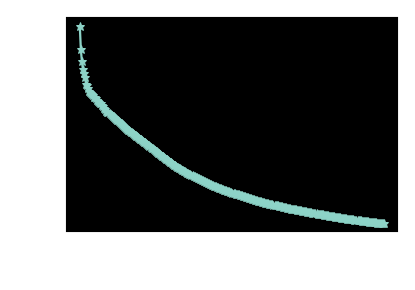




Iteration  309  Loss 0.13203169405460358


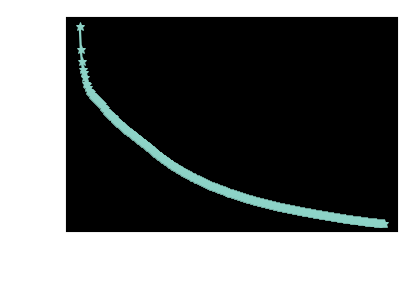




Iteration  319  Loss 0.1298278123140335


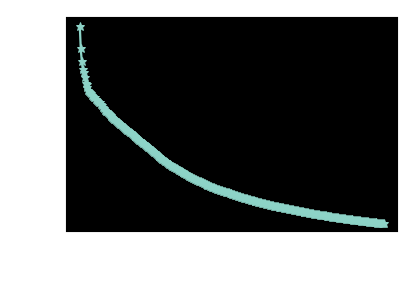




Iteration  329  Loss 0.12791895866394043


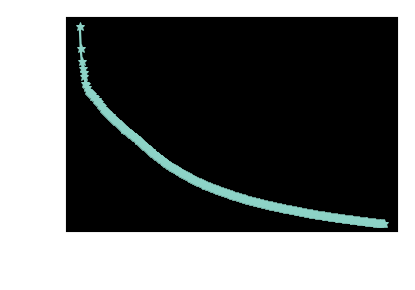




Iteration  339  Loss 0.12799781560897827


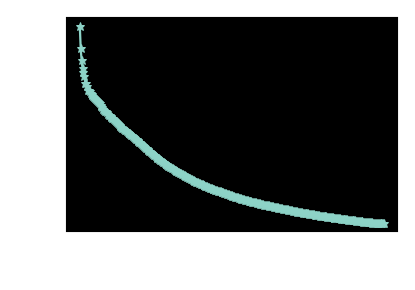




Iteration  349  Loss 0.12875643372535706


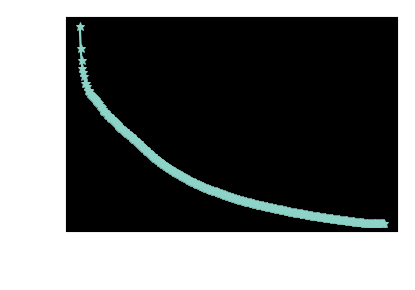




Iteration  359  Loss 0.12935331463813782


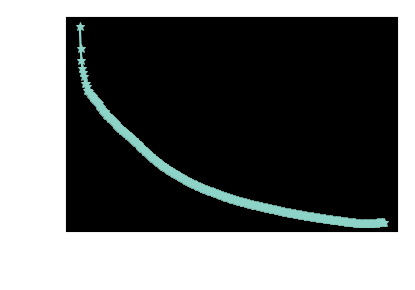




Iteration  369  Loss 0.1295725703239441


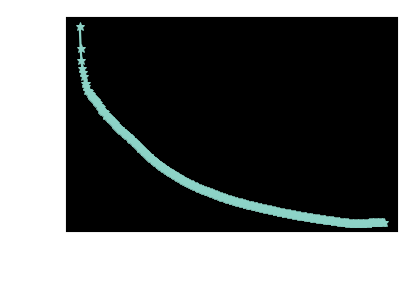




Iteration  379  Loss 0.1295127272605896


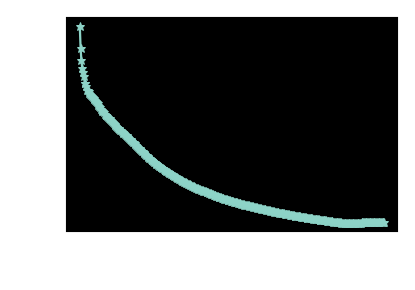




Iteration  389  Loss 0.12924528121948242


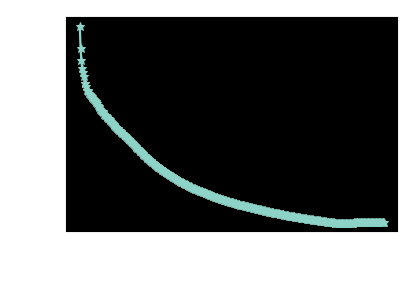




Iteration  399  Loss 0.12902750074863434


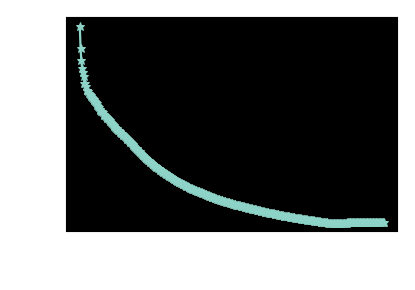




Iteration  409  Loss 0.12863025069236755


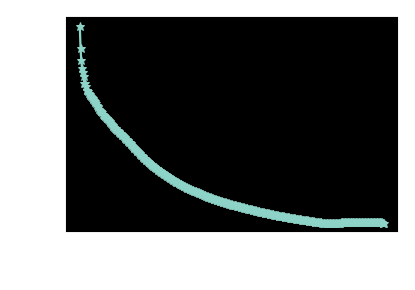




Iteration  419  Loss 0.12834802269935608


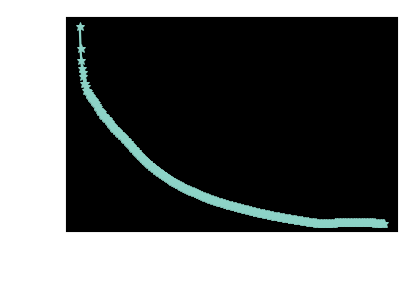




Iteration  429  Loss 0.12786315381526947


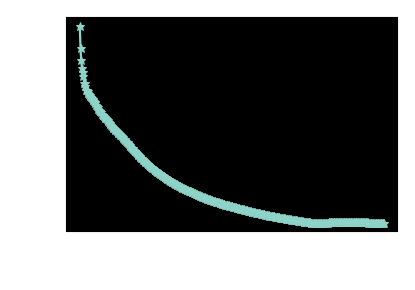




Iteration  439  Loss 0.12759317457675934


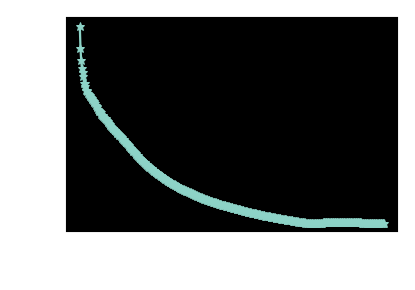




Iteration  449  Loss 0.12739934027194977


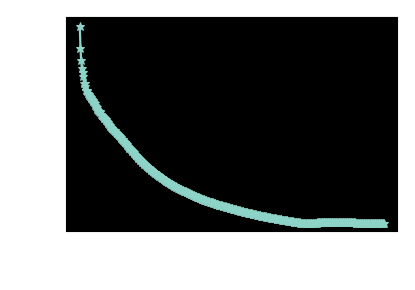




Iteration  459  Loss 0.12711726129055023


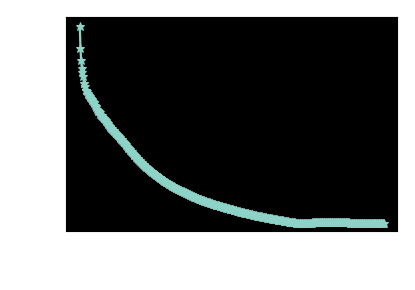




Iteration  469  Loss 0.12666232883930206


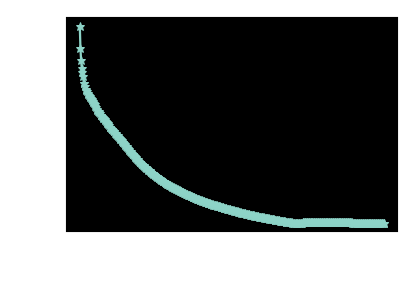




Iteration  479  Loss 0.1265229880809784


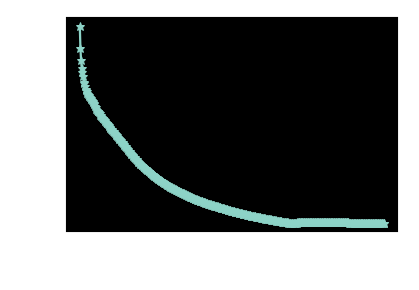




Iteration  489  Loss 0.1262257695198059


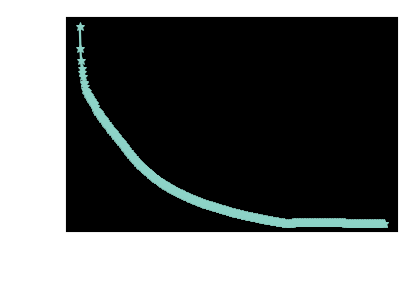




Iteration  499  Loss 0.12592796981334686


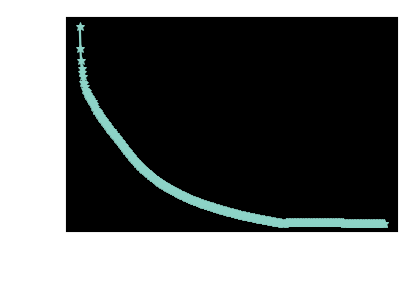




Iteration  509  Loss 0.12554983794689178


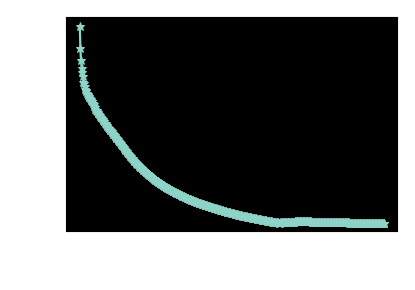




Iteration  519  Loss 0.1252593696117401


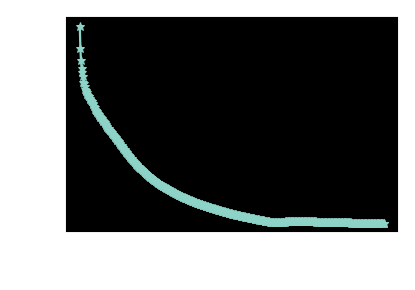




Iteration  529  Loss 0.12490583956241608


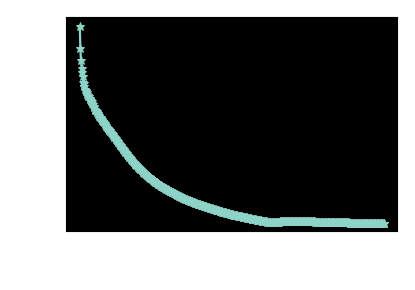




Iteration  539  Loss 0.12443726509809494


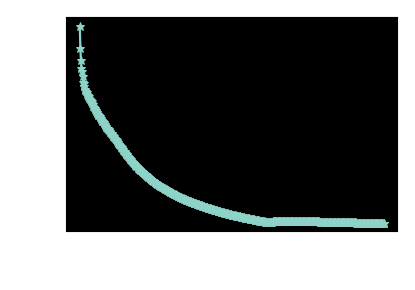




Iteration  549  Loss 0.12433610111474991


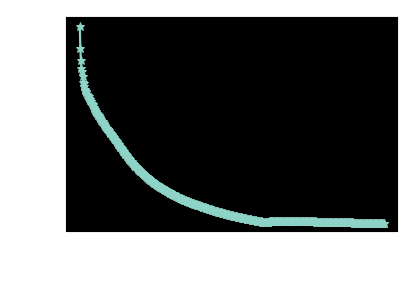




Iteration  559  Loss 0.12428303807973862


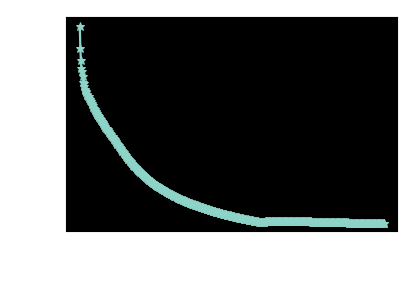




Iteration  569  Loss 0.12395195662975311


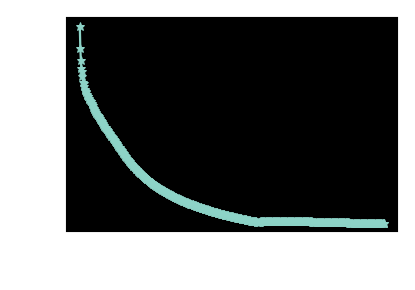




Iteration  579  Loss 0.12373027950525284


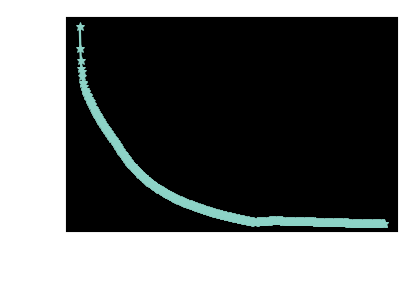




Iteration  589  Loss 0.12347108125686646


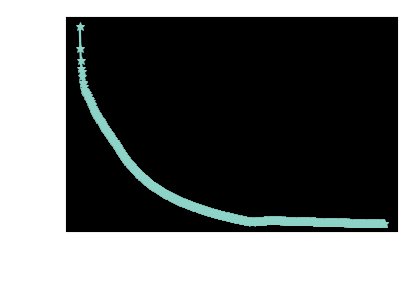




Iteration  599  Loss 0.12314362078905106


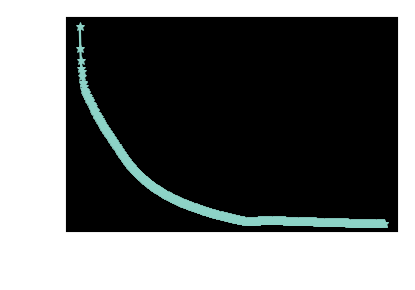




Iteration  609  Loss 0.12296567112207413


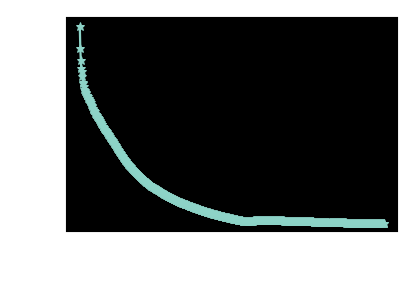




Iteration  619  Loss 0.12262861430644989


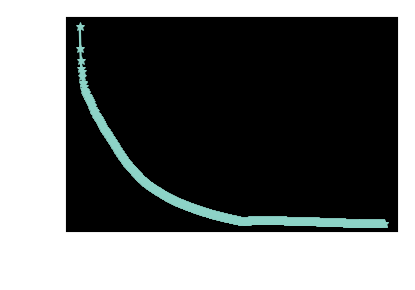




Iteration  629  Loss 0.12238369137048721


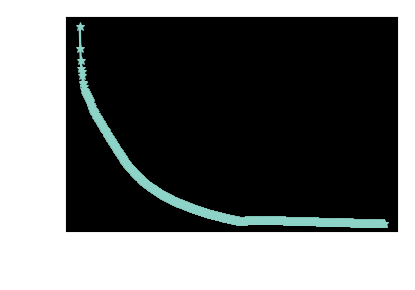




Iteration  639  Loss 0.12199972569942474


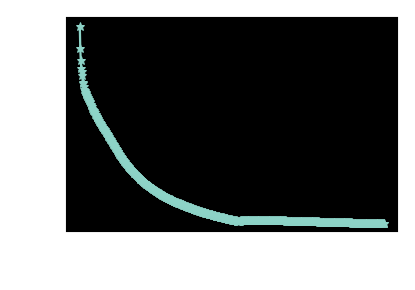




Iteration  649  Loss 0.12166330218315125


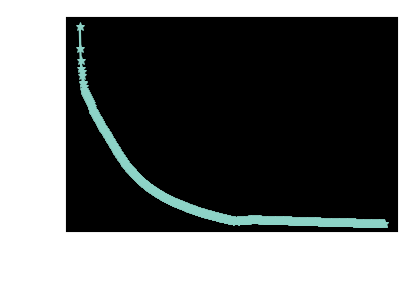




Iteration  659  Loss 0.12130369991064072


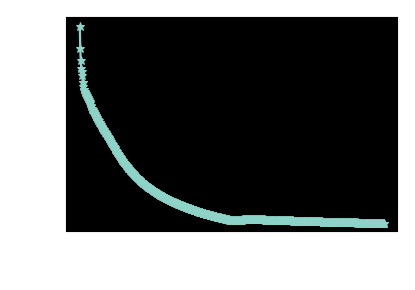




Iteration  669  Loss 0.12112061679363251


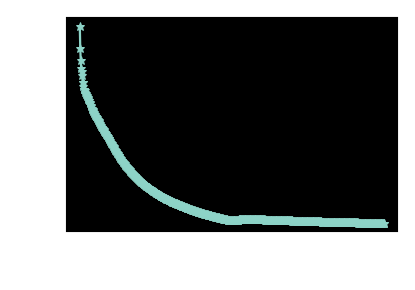




Iteration  679  Loss 0.12087149918079376


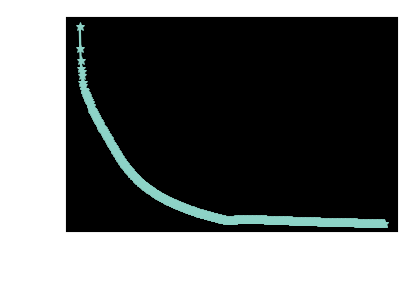




Iteration  689  Loss 0.12060748040676117


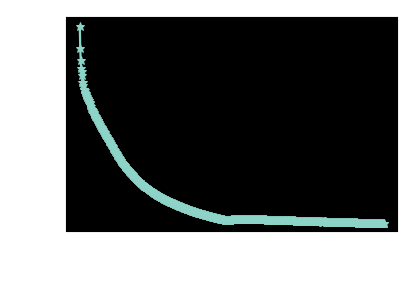




Iteration  699  Loss 0.12041808664798737


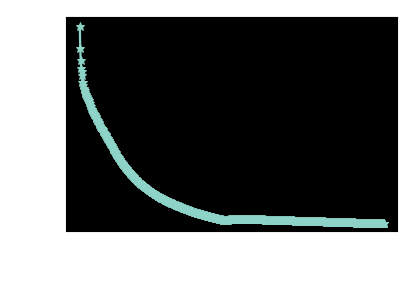




Iteration  709  Loss 0.12029731273651123


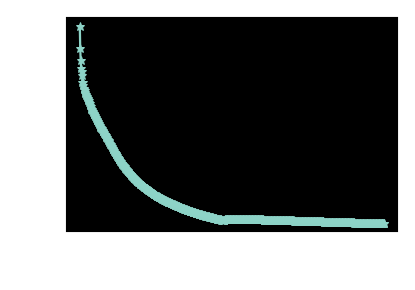




Iteration  719  Loss 0.12009768933057785


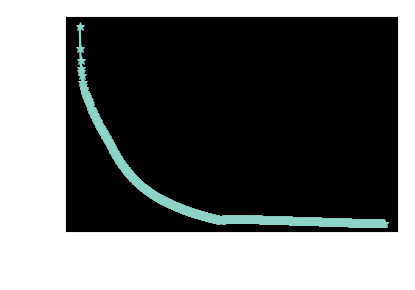




Iteration  729  Loss 0.11974179744720459


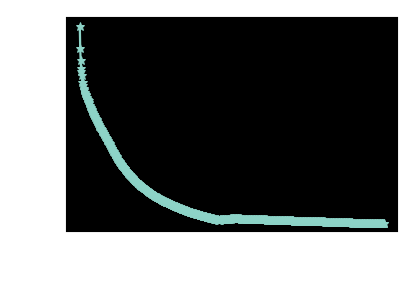




Iteration  739  Loss 0.11933046579360962


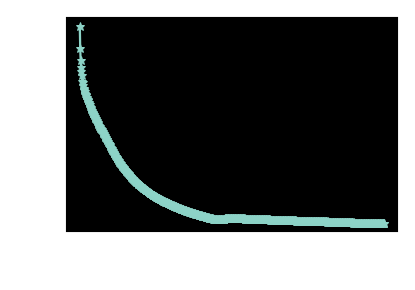




Iteration  749  Loss 0.11899110674858093


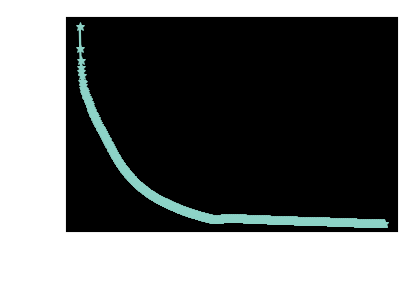




Iteration  759  Loss 0.11865178495645523


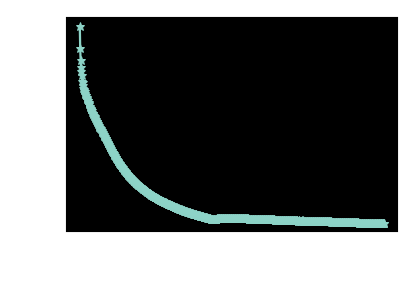




Iteration  769  Loss 0.11838053166866302


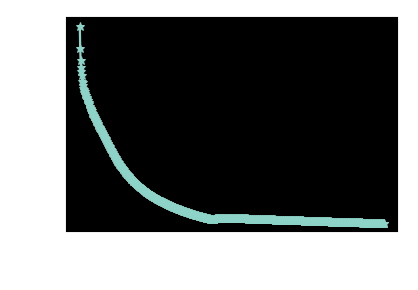




Iteration  779  Loss 0.11808869242668152


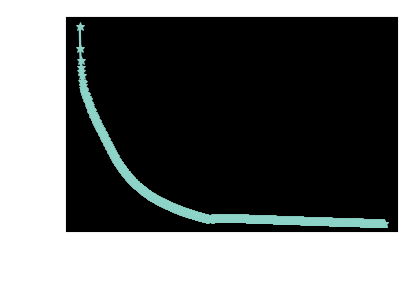




Iteration  789  Loss 0.11773497611284256


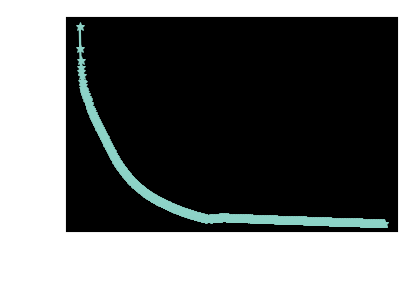




Iteration  799  Loss 0.11752300709486008


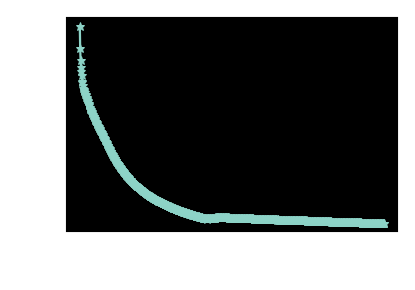




Iteration  809  Loss 0.11731868982315063


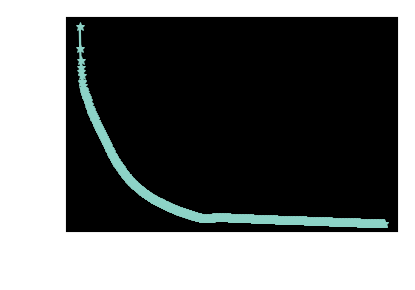




Iteration  819  Loss 0.11704430729150772


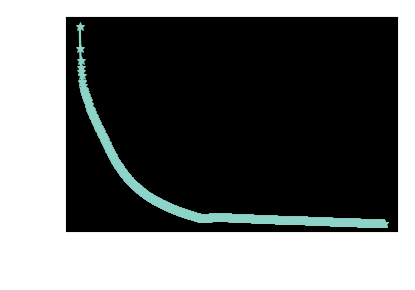




Iteration  829  Loss 0.11682358384132385


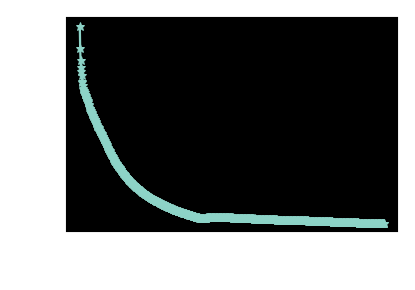




Iteration  839  Loss 0.11662467569112778


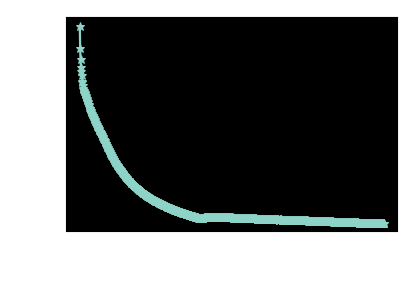




Iteration  849  Loss 0.1163407415151596


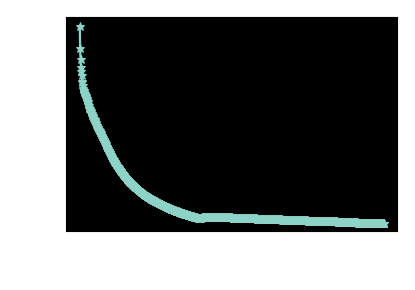




Iteration  859  Loss 0.11607938259840012


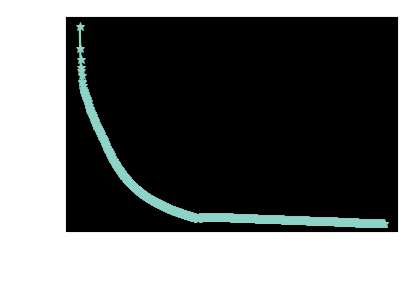




Iteration  869  Loss 0.11594163626432419


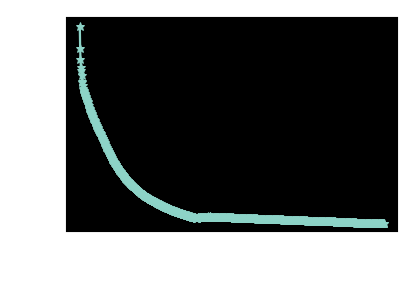




Iteration  879  Loss 0.11566022783517838


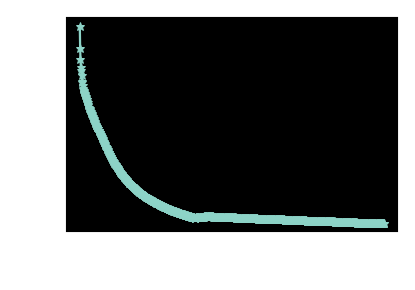




Iteration  889  Loss 0.115459144115448


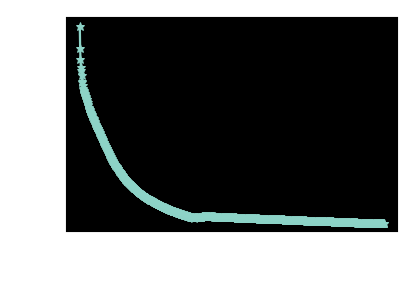




Iteration  899  Loss 0.11520390957593918


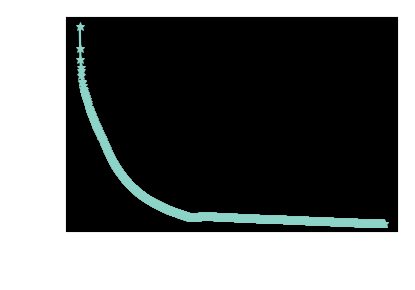




Iteration  909  Loss 0.11497863382101059


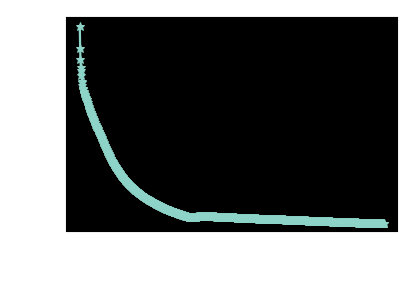




Iteration  919  Loss 0.11480912566184998


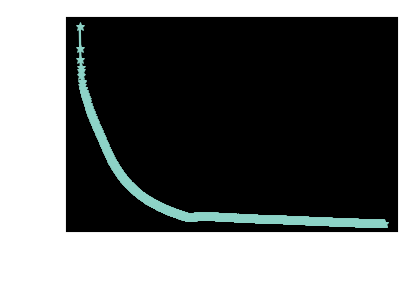




Iteration  929  Loss 0.11463558673858643


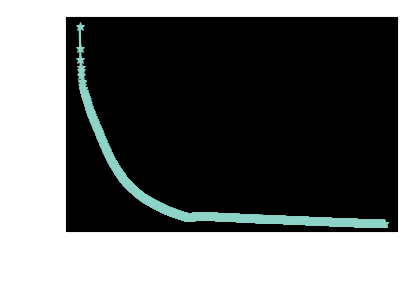




Iteration  939  Loss 0.11446383595466614


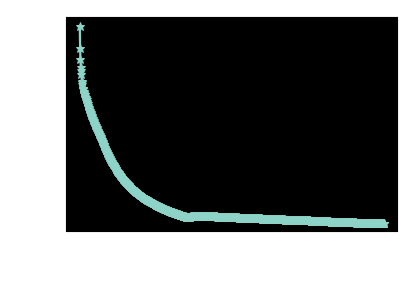




Iteration  949  Loss 0.1142953410744667


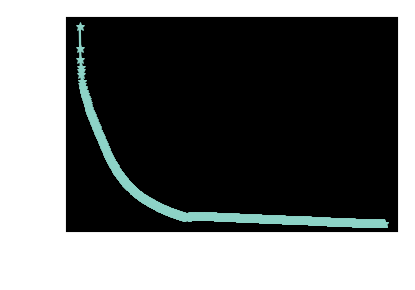




Iteration  959  Loss 0.11415141820907593


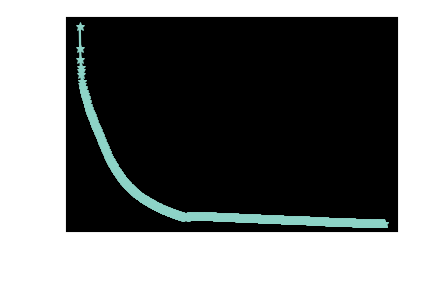




Iteration  969  Loss 0.11400435864925385


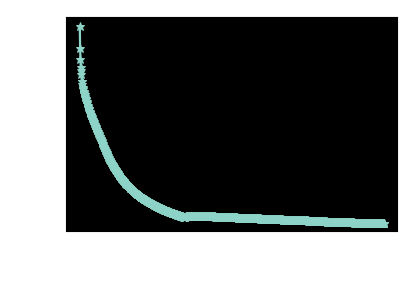




Iteration  979  Loss 0.11385045200586319


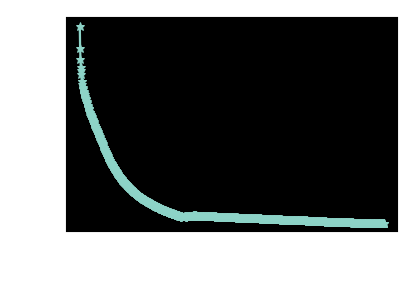




Iteration  989  Loss 0.11372820287942886


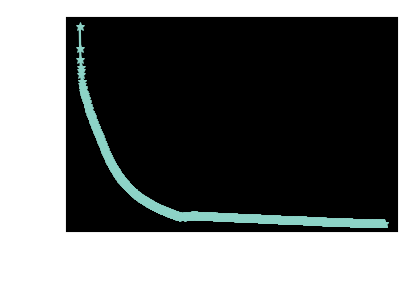




Iteration  999  Loss 0.11360537260770798


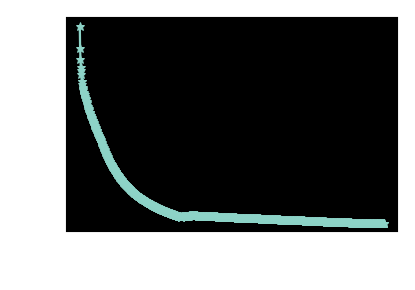

In [61]:
loss_history=train_setup(net_att,lr=0.01,n_batches=1000,batch_size=64,display_freq=10,device=device_gpu)

# Inference

In [70]:
def test(net,word,device='cpu'):
    net=net.eval().to(device)
    outputs=infer(net,word,30,device)
    hindi_output=''
    for out in outputs:
        val,indices=out.topk(1)
        index=indices.tolist()[0][0]
        if index==0:
            break
        hindi_char=hindi_alphabets[index+1]
        hindi_output+=hindi_char
    print(word+' - '+hindi_output)
    return hindi_output

In [62]:
def calc_accuracy(net,device='cpu'):
    net=net.eval().to(device)
    prediction=[]
    accuracy=0
    for i in range(len(test_data)):
        eng,hindi=test_data[i]
        gt=get_rep(hindi,hindi_alpha2index,device)
        outputs=infer(net,eng,gt.shape[0],device)
        correct=0
        for index,out in enumerate(outputs):
            
            val,indices=out.topk(1)
            hindi_pos=indices.tolist()[0]
            if hindi_pos[0]==gt[index][0]:
                correct+=1
                
        accuracy+=correct/gt.shape[0]
    accuracy/=len(test_data)
    return accuracy
    

In [71]:
accuracy=calc_accuracy(net)*100

In [72]:
accuracy_attn=calc_accuracy(net_att)*100

In [73]:
print('Accuracy w/o attention ',accuracy)

Accuracy w/o attention  67.80996531246537


In [74]:
print('Accuracy with attention ',accuracy_attn)

Accuracy with attention  68.84136030636029
